# Q1. What is the price distribution of menu items?

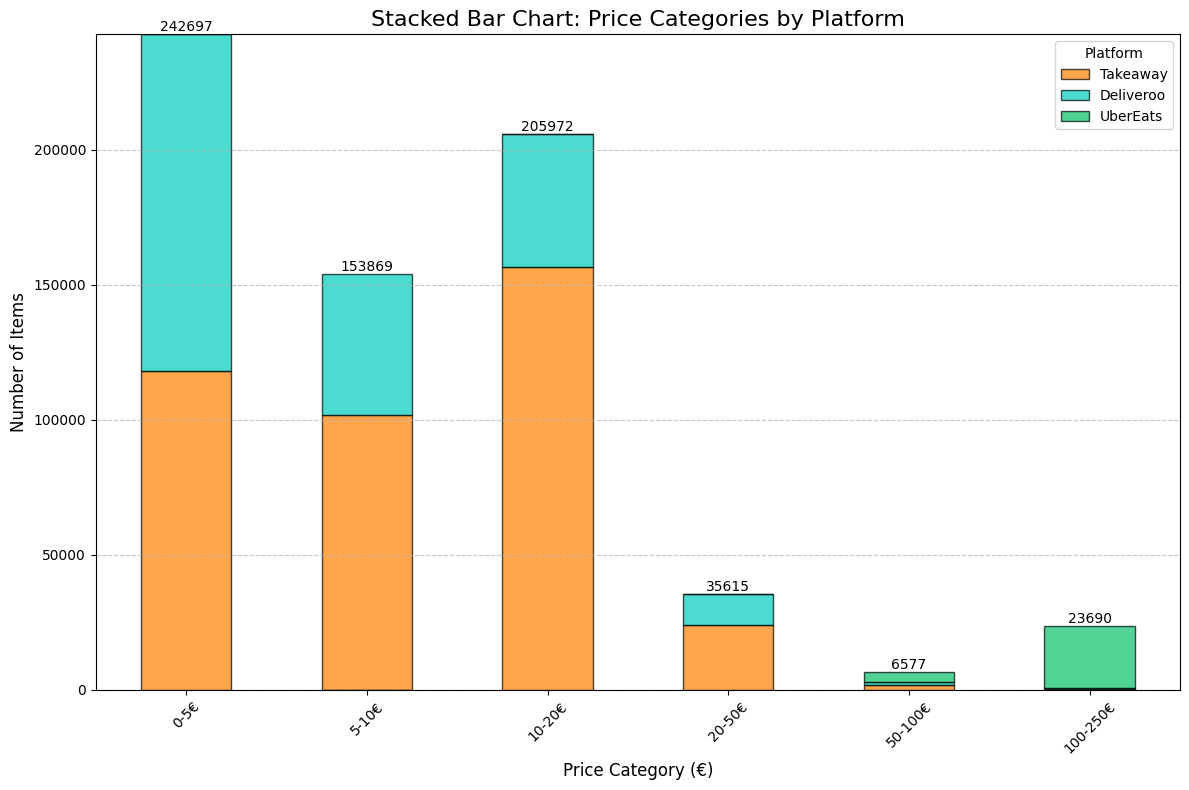

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Your database paths (use your real paths here)
databases = {
    "Takeaway":  r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db",
    "Deliveroo": r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db",
    "UberEats":  r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db",
}

def fetch_prices(db_path, table_name="menuItems", price_column="price"):
    # Fetch prices as floats from a specific table/column
    try:
        with sqlite3.connect(db_path) as conn:
            cursor = conn.cursor()
            query = f"""
                SELECT {price_column}
                FROM {table_name}
                WHERE {price_column} IS NOT NULL
                  AND TRIM({price_column}) <> ''
                  AND CAST({price_column} AS REAL) > 0;
            """
            cursor.execute(query)
            prices = [float(row[0]) for row in cursor.fetchall()]
        return prices
    except Exception as e:
        print(f"Error fetching data from {db_path}: {e}")
        return []

# Fetch prices for each platform (adjust table names if needed)
filtered_takeaway_prices  = fetch_prices(databases["Takeaway"],  "menuItems",  "price")
filtered_deliveroo_prices = fetch_prices(databases["Deliveroo"], "menu_items", "price")
filtered_ubereats_prices  = fetch_prices(databases["UberEats"],  "menu_items", "price")

# Define price bins
bins = [0, 5, 10, 20, 50, 100, 250]
labels = ['0-5€', '5-10€', '10-20€', '20-50€', '50-100€', '100-250€']

# Bin prices
takeaway_binned  = pd.cut(filtered_takeaway_prices,  bins=bins, labels=labels, right=False)
deliveroo_binned = pd.cut(filtered_deliveroo_prices, bins=bins, labels=labels, right=False)
ubereats_binned  = pd.cut(filtered_ubereats_prices,  bins=bins, labels=labels, right=False)

# Count bins 
takeaway_counts  = takeaway_binned.value_counts().reindex(labels, fill_value=0)
deliveroo_counts = deliveroo_binned.value_counts().reindex(labels, fill_value=0)
ubereats_counts  = ubereats_binned.value_counts().reindex(labels, fill_value=0)

# Combine into one DataFrame
bar_data = pd.DataFrame({
    "Price Category": labels,
    "Takeaway": takeaway_counts.values,
    "Deliveroo": deliveroo_counts.values,
    "UberEats": ubereats_counts.values
})

# Plot stacked bars (use the returned Axes for correct annotation placement)
ax = bar_data.set_index("Price Category").plot(
    kind="bar",
    stacked=True,
    color=["#FF8000", "#00CCBC", "#06C167"],  # Takeaway, Deliveroo, UberEats
    edgecolor="black",
    alpha=0.7,
    figsize=(12, 8),
)
ax.set_title("Stacked Bar Chart: Price Categories by Platform", fontsize=16)
ax.set_xlabel("Price Category (€)", fontsize=12)
ax.set_ylabel("Number of Items", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
ax.legend(title="Platform", fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add totals on top of each stacked bar
totals = bar_data[["Takeaway", "Deliveroo", "UberEats"]].sum(axis=1).values
for i, total in enumerate(totals):
    ax.text(i, total, str(int(total)), ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


# Q2.  What is the distribution of restaurants per location?

In [13]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Restaurants per location (Takeaway)
df_ta = q(conn, """
SELECT
  l.ID AS location_id,
  l.city,
  l.postalCode,
  l.latitude,
  l.longitude,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM ta.locations l
JOIN ta.locations_to_restaurants lr
  ON lr.location_id = l.ID
WHERE l.latitude IS NOT NULL AND l.longitude IS NOT NULL
GROUP BY l.ID, l.city, l.postalCode, l.latitude, l.longitude;
""")

# HeatMap expects [lat, lon, weight]
heat_data = df_ta[["latitude", "longitude", "restaurants"]].values.tolist()

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)
HeatMap(heat_data, radius=18, blur=15, min_opacity=0.3).add_to(m)

out_path = Path(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\heatmap_takeaway_restaurants_per_location.html").resolve()
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\heatmap_takeaway_restaurants_per_location.html


# deliveroo heatmap of restuarant locations 

Saved to: C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\heatmap_deliveroo_restaurants.html


# ubereats heat map of restuarant location

In [33]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Recreate connection 
conn = sqlite3.connect(DELIVEROO_DB)
conn.execute(f"ATTACH DATABASE '{UBEREATS_DB}' AS ue;")

# ----- Deliveroo heatmap (restaurants table in main) -----
df_deliveroo = q(conn, """
SELECT latitude, longitude
FROM restaurants
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)
HeatMap(df_deliveroo[["latitude", "longitude"]].values.tolist(), radius=18, blur=15, min_opacity=0.3).add_to(m)

out_del = Path(r"C:\Users\welde\Desktop\heatmap_deliveroo_restaurants.html")
m.save(str(out_del))
webbrowser.open(str(out_del))
print("Saved Deliveroo map to:", out_del)



df_ubereats = q(conn, """
SELECT latitude, longitude
FROM "ue"."locations"
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)
HeatMap(df_ubereats[["latitude", "longitude"]].values.tolist(), radius=18, blur=15, min_opacity=0.3).add_to(m)

out_ue = Path(r"C:\Users\welde\Desktop\heatmap_ubereats_restaurants.html")
m.save(str(out_ue))
webbrowser.open(str(out_ue))
print("Saved UberEats map to:", out_ue)


Saved Deliveroo map to: C:\Users\welde\Desktop\heatmap_deliveroo_restaurants.html
Saved UberEats map to: C:\Users\welde\Desktop\heatmap_ubereats_restaurants.html


In [27]:
q(conn, "PRAGMA .table_info(locations);")

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,1,None,0
1,1,name,TEXT,1,None,0
2,2,region,TEXT,1,None,0
3,3,latitude,double precision,1,None,0
4,4,longitude,double precision,1,None,0
5,5,visited_time,timestamp with time zone,0,None,0


In [35]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

conn = sqlite3.connect(DELIVEROO_DB)
conn.execute(f"ATTACH DATABASE '{TAKEAWAY_DB}' AS ta;")
conn.execute(f"ATTACH DATABASE '{UBEREATS_DB}' AS ue;")

df_del = q(conn, """
SELECT latitude, longitude
FROM restaurants
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

df_ta = q(conn, """
SELECT
  l.latitude,
  l.longitude,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM ta.locations l
JOIN ta.locations_to_restaurants lr ON lr.location_id = l.ID
WHERE l.latitude IS NOT NULL AND l.longitude IS NOT NULL
GROUP BY l.latitude, l.longitude;
""")

df_ue = q(conn, """
SELECT latitude, longitude
FROM ue.locations
WHERE latitude IS NOT NULL AND longitude IS NOT NULL;
""")

# Different color gradients per platform
grad_deliveroo = {0.2: "#b2f5ea", 0.5: "#00ccbc", 0.8: "#006d66"}  # teal
grad_takeaway  = {0.2: "#ffe0b2", 0.5: "#ff8000", 0.8: "#8a3d00"}  # orange
grad_ubereats  = {0.2: "#c8f7d0", 0.5: "#06c167", 0.8: "#014d2a"}  # green

m = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

fg_del = folium.FeatureGroup(name="Deliveroo (restaurants)", show=True)
HeatMap(
    df_del[["latitude", "longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_deliveroo
).add_to(fg_del)
fg_del.add_to(m)

fg_ta = folium.FeatureGroup(name="Takeaway (restaurants per location)", show=False)
HeatMap(
    df_ta[["latitude", "longitude", "restaurants"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_takeaway
).add_to(fg_ta)
fg_ta.add_to(m)

fg_ue = folium.FeatureGroup(name="UberEats (locations)", show=False)
HeatMap(
    df_ue[["latitude", "longitude"]].values.tolist(),
    radius=18, blur=15, min_opacity=0.3,
    gradient=grad_ubereats
).add_to(fg_ue)
fg_ue.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

out_path = Path(r"C:\Users\welde\Desktop\heatmap_toggle_all_platforms.html")
m.save(str(out_path))
webbrowser.open(str(out_path))
print("Saved to:", out_path)


Saved to: C:\Users\welde\Desktop\heatmap_toggle_all_platforms.html


# The World Hummus Order (WHO); top 3 hummus serving restaurants.

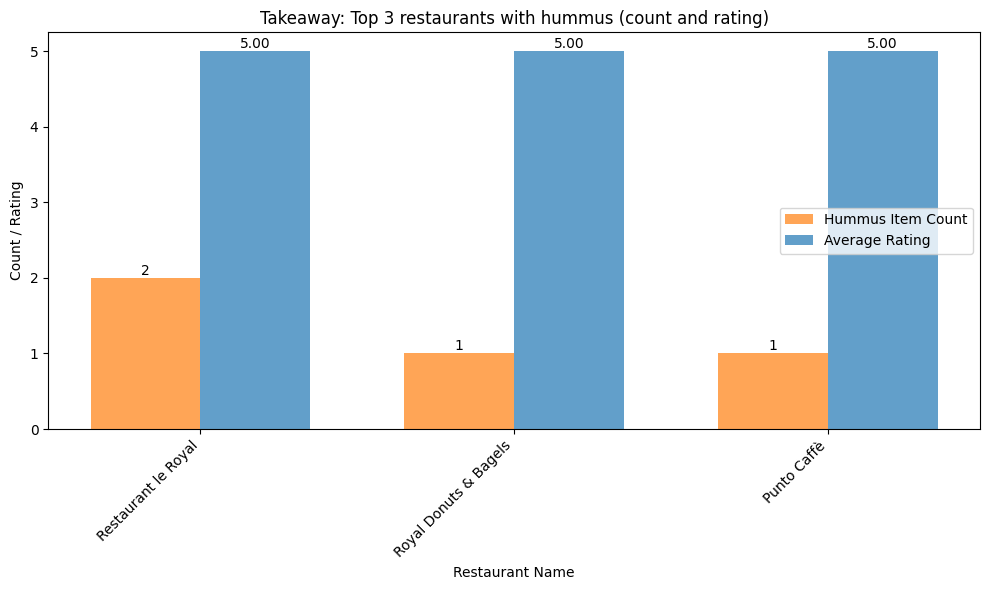

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

takeaway_hummus_sql = """
SELECT
    r.name AS restaurant_name,
    ROUND(AVG(CAST(r.ratings AS REAL)), 2) AS avg_rating,
    COUNT(mi.name) AS hummus_item_count
FROM ta.menuItems mi
JOIN ta.restaurants r
  ON mi.primarySlug = r.primarySlug
WHERE LOWER(mi.name) LIKE '%hummus%'
GROUP BY r.primarySlug, r.name
ORDER BY avg_rating DESC, hummus_item_count DESC
LIMIT 3;
"""

df = q(conn, takeaway_hummus_sql)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(df))

bars1 = ax.bar(
    index,
    df["hummus_item_count"],
    bar_width,
    label="Hummus Item Count",
    color="tab:orange",
    alpha=0.7
)

bars2 = ax.bar(
    [i + bar_width for i in index],
    df["avg_rating"],
    bar_width,
    label="Average Rating",
    color="tab:blue",
    alpha=0.7
)

ax.set_xlabel("Restaurant Name")
ax.set_ylabel("Count / Rating")
ax.set_title("Takeaway: Top 3 restaurants with hummus (count and rating)")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df["restaurant_name"], rotation=45, ha="right")
ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", ha="center", va="bottom")

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()
